# &#x1F4D1; &nbsp; <span style="color:red"> Reflections. Artificial Intelligence for Robotics. Sections 15-18</span>

##   &#x1F916; &nbsp; <span style="color:red">Links</span>

##   &#x1F916; &nbsp; <span style="color:red">Libraries</span>

In [16]:
from math import *
import numpy as np
import pandas as pd
import random
import os
from time import time
from copy import deepcopy

In [2]:
from IPython.display import display, Image
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox
%matplotlib inline

##   &#x1F916; &nbsp; <span style="color:red">Section 15. PID Control</span>

### Notes

### Examples

### Quizes

In [3]:
# Quiz: Robot Motion
# Red

In [4]:
# Quiz: Smoothing Algorithm
# original path

In [5]:
# Quiz: Smoothing Algorithm 2
# no path    

In [ ]:
# Quiz: Smoothing Algorithm 3
# smooth path

In [6]:
# Quiz: Path Smoothing
# The formula you need to use in the exercise is as follows. 
# Note that it is a little different from the ones in the video.

# yi <- yi + alpha * (xi - yi) + beta * (y_i+1 + y_i-1 - 2 * yi)

In [15]:
# -----------
# User Instructions
#
# Define a function smooth that takes a path as its input
# (with optional parameters for weight_data, weight_smooth,
# and tolerance) and returns a smooth path. The first and 
# last points should remain unchanged.
#
# Smoothing should be implemented by iteratively updating
# each entry in newpath until some desired level of accuracy
# is reached. The update should be done according to the
# gradient descent equations given in the instructor's note
# below (the equations given in the video are not quite 
# correct).
# -----------

# thank you to EnTerr for posting this on our discussion forum
def printpaths(path,newpath):
    for old,new in zip(path,newpath):
        print ('['+ ', '.join('%.3f'%x for x in old) + \
               '] -> ['+ ', '.join('%.3f'%x for x in new) +']')

# Don't modify path inside your function.
path = [[0, 0],
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.5, weight_smooth = 0.1, tolerance = 0.000001):

    # Make a deep copy of path into newpath
    newpath = deepcopy(path)

    #######################
    ### ENTER CODE HERE ###
    #######################
    
    while True:
        diff = 0.
        for i in range(1, len(path)-1):
            for j in range(len(path[i])):
                current_point = newpath[i][j]
                
                newpath[i][j] = newpath[i][j] + weight_data * (path[i][j] - newpath[i][j]) + \
                weight_smooth * (newpath[i+1][j] + newpath[i-1][j] - 2 * newpath[i][j])
                
                diff += abs(current_point - newpath[i][j])
                
        if diff < tolerance:
            break
    
    return newpath # Leave this line for the grader!

printpaths(path,smooth(path))


[0.000, 0.000] -> [0.000, 0.000]
[0.000, 1.000] -> [0.021, 0.979]
[0.000, 2.000] -> [0.149, 1.851]
[1.000, 2.000] -> [1.021, 1.979]
[2.000, 2.000] -> [2.000, 2.000]
[3.000, 2.000] -> [2.979, 2.021]
[4.000, 2.000] -> [3.851, 2.149]
[4.000, 3.000] -> [3.979, 3.021]
[4.000, 4.000] -> [4.000, 4.000]


In [3]:
# Quiz: Zero Data Weight
# straight line

In [4]:
# Quiz: PID Control
# steer in proportion to CTE

In [17]:
# Quiz: Proportional Control
# overshoots

In [39]:
# Quiz: Implement P Controller
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# Note that tau is called "param" in the function
# below.
#
# Your code should print output that looks like
# the output shown in the video. That is, at each step:
# print myrobot, steering
#
# Only modify code at the bottom!
# ------------

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        # res = Robot()
        # res.length = self.length
        # res.steering_noise = self.steering_noise
        # res.distance_noise = self.distance_noise
        # res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return ('[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation))

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run
robot = Robot()
robot.set(0, 1, 0) 

def run(robot, tau, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    for i in range(n):
        x, y = robot.x, robot.y
        x_trajectory.append(x)
        y_trajectory.append(y)
        
        steering = - tau * y
        print(robot, steering)
        
        robot.move(steering, speed)
    
    return x_trajectory, y_trajectory
   
x_trajectory, y_trajectory = run(robot, 0.1)

[x=0.00000 y=1.00000 orient=0.00000] -0.1
[x=1.00000 y=0.99749 orient=6.27817] -0.0997491638459
[x=1.99997 y=0.98997 orient=6.27316] -0.0989972950612
[x=2.99989 y=0.97747 orient=6.26820] -0.0977469440459
[x=3.99973 y=0.96003 orient=6.26330] -0.0960031957433
[x=4.99948 y=0.93774 orient=6.25848] -0.0937736475381
[x=5.99912 y=0.91068 orient=6.25378] -0.0910683732206
[x=6.99861 y=0.87900 orient=6.24921] -0.0878998733516
[x=7.99796 y=0.84283 orient=6.24481] -0.0842830124796
[x=8.99714 y=0.80235 orient=6.24058] -0.0802349437746
[x=9.99614 y=0.75775 orient=6.23656] -0.0757750217292
[x=10.99497 y=0.70925 orient=6.23277] -0.0709247036578
[x=11.99360 y=0.65707 orient=6.22921] -0.0657074407797
[x=12.99206 y=0.60149 orient=6.22592] -0.060148559709
[x=13.99033 y=0.54275 orient=6.22291] -0.0542751351986
[x=14.98843 y=0.48116 orient=6.22020] -0.0481158549857
[x=15.98637 y=0.41701 orient=6.21779] -0.0417008775783
[x=16.98416 y=0.35062 orient=6.21570] -0.0350616837984
[x=17.98183 y=0.28231 orient=6.213

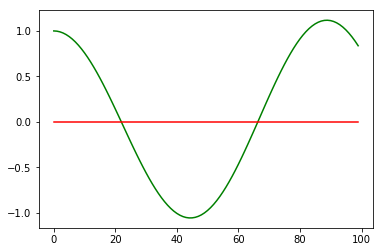

In [40]:
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='proportional controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')

In [46]:
# Quiz: Oscillations
# faster
x_trajectory, y_trajectory = run(robot, 0.3)

[x=490.55092 y=4.10820 orient=6.09068] -1.23246063298
[x=491.52726 y=3.89243 orient=6.04068] -1.16772862864
[x=492.49159 y=3.62813 orient=5.99068] -1.0884385718
[x=493.44151 y=3.31596 orient=5.94068] -0.994788646299
[x=494.37464 y=2.95671 orient=5.89068] -0.887012928188
[x=495.28865 y=2.55127 orient=5.84068] -0.76538080063
[x=496.18170 y=2.10153 orient=5.79264] -0.630458051633
[x=497.05498 y=1.61443 orient=5.75615] -0.484330032835
[x=497.91257 y=1.10015 orient=5.72984] -0.330045292791
[x=498.75880 y=0.56736 orient=5.71272] -0.170207309272
[x=499.59812 y=0.02372 orient=5.70412] -0.00711609366911
[x=500.43509 y=-0.52352 orient=5.70377] 0.157056019813
[x=501.27403 y=-1.06774 orient=5.71168] 0.320321907215
[x=502.11957 y=-1.60163 orient=5.72827] 0.480490422584
[x=502.97629 y=-2.11737 orient=5.75433] 0.635211123127
[x=503.84877 y=-2.60589 orient=5.79119] 0.78176703189
[x=504.74152 y=-3.05621 orient=5.84083] 0.91686339699
[x=505.65559 y=-3.46152 orient=5.89083] 1.03845465725
[x=506.58878 y=-

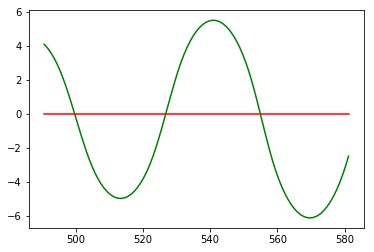

In [47]:
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='proportional controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')

##   &#x1F916; &nbsp; <span style="color:red">Section 16. Problem Set 5</span>

##   &#x1F916; &nbsp; <span style="color:red">Section 17. Problem Set 5 Help</span>

##   &#x1F916; &nbsp; <span style="color:red">Section 18. Office Hours Week 5</span>